In [1]:
import os
import pandas as pd
import numpy as np

def load_titanic_data(filename, folder="Data"):
    csv_path = os.path.join(folder, filename)
    return pd.read_csv(csv_path)

In [62]:
titanic_train = load_titanic_data("train.csv")
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


So initial lessons to learn: Age has over 150 missing values which is significant in this dataset size Cabin has 22% population which is very poor could initially transform into a new column of has cabin which is binary, not sure if a location from cabin can be gleaned to help predict survival rates based on where in the ship passengers had cabins? Maybe those with cabins could be more likely to have been in them at the time of sinking?

Need to remove PassengerId from training process

Only numerical fields which are related numerical - age and fare. The rest are categorical

In [4]:
204/891 * 100 #Cabin population rate

22.895622895622896

In [5]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


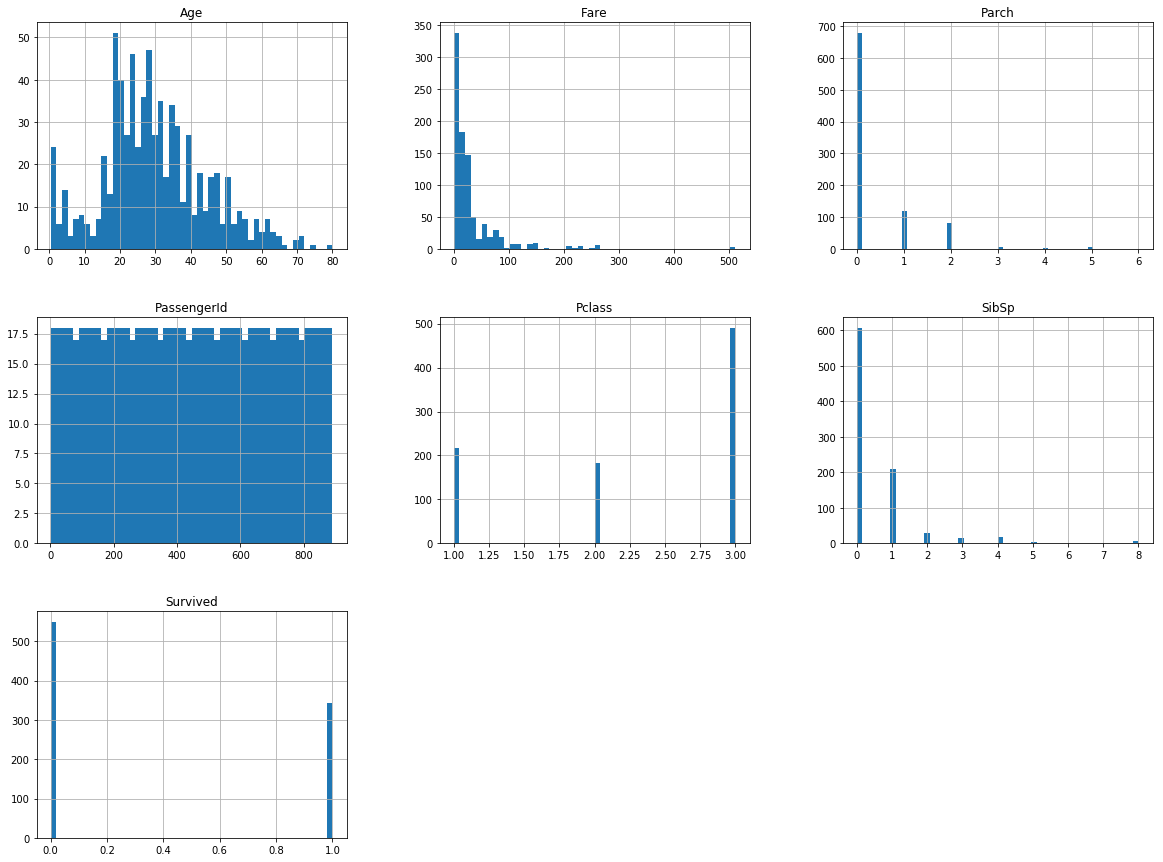

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

Splitting out a title field from the name seems sensible and setting it's values to true/false
Flagging if a passenger had a Cabin or not - perhaps cabin type matters as well
Trying to combine Parch and SibSp into a Family feature - saw someone else had done this and sounded sensible

In [370]:
def AddTitle(data):
    data["Mr"] = 0
    data["Mrs"] = 0
    data["Master"] = 0
    data["Miss"] = 0
    data["Other"] = 0
    data.loc[data["Name"].str.contains("Mr.", regex=False), "Mr"] = 1
    data.loc[data["Name"].str.contains("Mrs.", regex=False), "Mrs"] = 1
    data.loc[data["Name"].str.contains("Master.", regex=False), "Master"] = 1
    data.loc[data["Name"].str.contains("Miss.", regex=False), "Miss"] = 1
    data.loc[data["Mr"] + data["Mrs"] + data["Master"] + data["Miss"] == 0, "Other"] = 1
    
def AddHasCabin(data):
    data["HasCabin"] = data["Cabin"]
    data["HasCabin"] = data["HasCabin"].fillna(value=0)
    data.loc[data["HasCabin"] != 0, "HasCabin"] = 1
    
def CombineFamily(data):
    data["Family"] = data["Parch"] + data["SibSp"]
    
def CabinType(data):
    data["CabinLetter"] = data["Cabin"].str[0]
    
def AgeBrackets(data):
    data["Baby"] = 0
    data["Child"] = 0
    data["YoungAdult"] = 0
    data["Adult"] = 0
    data["OldAdult"] = 0
    data.loc[data["Age"] < 3, "Baby"] = 1
    data.loc[(data["Age"] >= 3) & (data["Age"] < 14), "Child"] = 1
    data.loc[(data["Age"] >= 14) & (data["Age"] < 24), "YoungAdult"] = 1
    data.loc[(data["Age"] >= 24) & (data["Age"] < 40), "Adult"] = 1
    data.loc[data["Age"] >= 40, "OldAdult"] = 1

S    644
C    168
Q     77
       2
Name: Embarked, dtype: int64

Diving in and looking at some classification to see how it looks as a first pass. Still need to do more work on unused fields currently

In [438]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

titanic_training = titanic_train.copy()

def PrepData(data):
    AddTitle(data)
    #AddHasCabin(data)
    CombineFamily(data)
    data.Embarked.fillna('S', inplace=True)
    data.loc[data["Embarked"] == "", "Embarked"] = "S"
    #data.Cabin.fillna('Z', inplace=True)
    #data.Age.fillna((data["Age"].median()), inplace=True)
    #CabinType(data)
    #AgeBrackets(data)
    
cat_attribs = ["Sex","Embarked","Pclass"]
#titanic_num = titanic_training.drop(["PassengerId","Name","Sex","Ticket","Cabin","Embarked","Survived","Parch","SibSp","Pclass"], axis=1)
#num_attribs = list(titanic_num)
num_attribs = ['Age', 'Fare', 'Mr', 'Mrs', 'Master', 'Miss', 'Other', 'Family']
print(num_attribs)
print(cat_attribs)

#train_set, test_set = train_test_split(titanic_training, test_size=0.2, random_state=42)

   
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from future_encoders import OneHotEncoder

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

#print("Babies:",titanic_training.Baby.sum())
#print("Children:",titanic_training.Child.sum())
#print("Young Adults:",titanic_training.YoungAdult.sum())
#print("Adults:",titanic_training.Adult.sum())
#print("Old Adults:",titanic_training.OldAdult.sum())

#train_labels, test_labels = train_set["Survived"], test_set["Survived"]
train_labels = titanic_training["Survived"]
PrepData(titanic_training)

print(titanic_training.head(10))
print(titanic_training.info())
titanic_prepared = full_pipeline.fit_transform(titanic_training)

['Age', 'Fare', 'Mr', 'Mrs', 'Master', 'Miss', 'Other', 'Family']
['Sex', 'Embarked', 'Pclass']
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr

In [417]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(titanic_prepared, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [418]:
cross_val_score(sgd_clf, titanic_prepared, train_labels, cv=3, scoring="accuracy")

array([0.59259259, 0.7003367 , 0.72727273])

In [419]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(titanic_prepared, train_labels)
cross_val_score(forest_clf, titanic_prepared, train_labels, cv=3, scoring="accuracy")

array([0.78114478, 0.8047138 , 0.8047138 ])

In [420]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(titanic_prepared, train_labels)
cross_val_score(knn_clf, titanic_prepared, train_labels, cv=3, scoring="accuracy")

array([0.78451178, 0.81144781, 0.8013468 ])

Initial results are poor but promising. I feel like some parameter tuning could help but there's probably more need for improvement in the input parameters

In [440]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {
        'n_estimators': randint(low=20, high=200),
        'max_features': randint(low=7, high=10),
    }

forest_clf = RandomForestClassifier(random_state=42)
grid_search = RandomizedSearchCV(forest_clf, param_grid, n_iter = 20, cv=5, verbose=3, return_train_score=False)
grid_search.fit(titanic_prepared, train_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] max_features=7, n_estimators=57 .................................
[CV]  max_features=7, n_estimators=57, score=0.7877094972067039, total=   0.0s
[CV] max_features=7, n_estimators=57 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_features=7, n_estimators=57, score=0.7877094972067039, total=   0.0s
[CV] max_features=7, n_estimators=57 .................................
[CV]  max_features=7, n_estimators=57, score=0.8595505617977528, total=   0.0s
[CV] max_features=7, n_estimators=57 .................................
[CV]  max_features=7, n_estimators=57, score=0.7865168539325843, total=   0.0s
[CV] max_features=7, n_estimators=57 .................................
[CV]  max_features=7, n_estimators=57, score=0.8135593220338984, total=   0.0s
[CV] max_features=8, n_estimators=73 .................................
[CV]  max_features=8, n_estimators=73, score=0.7988826815642458, total=   0.0s
[CV] max_features=8, n_estimators=73 .................................
[CV]  max_features=8, n_estimators=73, score=0.7988826815642458, total=   0.1s
[CV] max_features=8, n_estimators=73 .................................
[CV]  max_features=8, n_estimators=73, score=0.8651685393258427, total=   0.0s
[CV] max_features=8, 

[CV]  max_features=9, n_estimators=88, score=0.8156424581005587, total=   0.1s
[CV] max_features=9, n_estimators=88 .................................
[CV]  max_features=9, n_estimators=88, score=0.8651685393258427, total=   0.1s
[CV] max_features=9, n_estimators=88 .................................
[CV]  max_features=9, n_estimators=88, score=0.7865168539325843, total=   0.1s
[CV] max_features=9, n_estimators=88 .................................
[CV]  max_features=9, n_estimators=88, score=0.8135593220338984, total=   0.1s
[CV] max_features=8, n_estimators=124 ................................
[CV]  max_features=8, n_estimators=124, score=0.7988826815642458, total=   0.1s
[CV] max_features=8, n_estimators=124 ................................
[CV]  max_features=8, n_estimators=124, score=0.7988826815642458, total=   0.1s
[CV] max_features=8, n_estimators=124 ................................
[CV]  max_features=8, n_estimators=124, score=0.8651685393258427, total=   0.1s
[CV] max_features=

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   20.6s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEB560E4E0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001BEB68AF550>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=False, scoring=None, verbose=3)

In [441]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

array = []
cvres = grid_search.cv_results_
for mean_score, features, estimators in zip(cvres["mean_test_score"], cvres["param_max_features"], cvres["param_n_estimators"]):
    print(np.sqrt(mean_score), 'max_features:', features, 'n_estimators:', estimators)
    array.append([np.sqrt(mean_score),features,estimators])
    
print(sorted(array, reverse=True))

#feature_importances = grid_search.best_estimator_.feature_importances_
#sorted(feature_importances)

#extra_attribs = ["Mr","Mrs","Master","Miss","Other","HasCabin","Family","CabinLetter","Baby","Child","YoungAdult","Adult","OldAdult"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2]) + list(cat_encoder.categories_[3])
#print(list(titanic_num), cat_one_hot_attribs)
#attributes = list(titanic_num) + cat_one_hot_attribs
#sorted(zip(feature_importances, attributes), reverse = True)

{'max_features': 9, 'n_estimators': 108}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=108, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.8983086739117798 max_features: 7 n_estimators: 57
0.9008039805905674 max_features: 8 n_estimators: 73
0.8995571924766518 max_features: 7 n_estimators: 156
0.9001808023903551 max_features: 8 n_estimators: 81
0.9063933040070528 max_features: 9 n_estimators: 108
0.9008039805905674 max_features: 8 n_estimators: 117
0.9008039805905674 max_features: 8 n_estimators: 151
0.9045340337332909 max_features: 9 n_estimators: 87
0.8995571924766518 max_features: 7 n_estimators: 53
0.9057739713047366 max_features: 9 n_estimators: 71
0.9014267279726507 max_features:

In [442]:
scores_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')
scores_df

,mean_fit_time,mean_score_time,mean_test_score,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_fit_time,std_score_time,std_test_score
16,0.077636,0.002603,0.821549,9,40,"{'max_features': 9, 'n_estimators': 40}",1,0.826816,0.804469,0.870787,0.792135,0.813559,0.008938,0.002156,0.027093
4,0.200174,0.013767,0.821549,9,108,"{'max_features': 9, 'n_estimators': 108}",1,0.815642,0.821229,0.865169,0.786517,0.819209,0.010609,0.006136,0.025167
9,0.138508,0.008203,0.820426,9,71,"{'max_features': 9, 'n_estimators': 71}",3,0.815642,0.815642,0.870787,0.786517,0.813559,0.002358,0.000743,0.027476
11,0.165399,0.004412,0.820426,9,88,"{'max_features': 9, 'n_estimators': 88}",3,0.821229,0.815642,0.865169,0.786517,0.813559,0.009690,0.003828,0.025372
17,0.133107,0.011478,0.818182,9,73,"{'max_features': 9, 'n_estimators': 73}",5,0.815642,0.815642,0.859551,0.786517,0.813559,0.002059,0.003503,0.023431
7,0.165323,0.008933,0.818182,9,87,"{'max_features': 9, 'n_estimators': 87}",5,0.815642,0.815642,0.859551,0.786517,0.813559,0.008477,0.003922,0.023431
13,0.364055,0.017971,0.814815,8,199,"{'max_features': 8, 'n_estimators': 199}",7,0.798883,0.810056,0.853933,0.786517,0.824859,0.014695,0.006817,0.023265
14,0.302048,0.015948,0.812570,8,152,"{'max_features': 8, 'n_estimators': 152}",8,0.798883,0.804469,0.865169,0.786517,0.807910,0.016096,0.000143,0.027266
10,0.371401,0.019786,0.812570,9,197,"{'max_features': 9, 'n_estimators': 197}",8,0.793296,0.804469,0.859551,0.786517,0.819209,0.009968,0.007187,0.025944
12,0.227086,0.013999,0.811448,8,124,"{'max_features': 8, 'n_estimators': 124}",10,0.798883,0.798883,0.865169,0.786517,0.807910,0.006788,0.001794,0.027688


In [424]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [3,4,5], 'weights': ["uniform","distance"]},
]

knn_clf = KNeighborsClassifier(n_jobs=-1)
grid_search_knn = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search_knn.fit(titanic_prepared, train_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.7653631284916201, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.8044692737430168, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV]  n_neighbors=3, weights=uniform, score=0.8089887640449438, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.8033707865168539, total=   0.0s
[CV] n_neighbors=3, weights=uniform ..................................
[CV]  n_neighbors=3, weights=uniform, score=0.807909604519774, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.7877094972067039, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.776536312849162, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.8089887640449438, total=   0.0s
[CV] n_neighbors=3, weights=distance .................................
[CV]  n_neighbors=3, weights=distance, score=0.7808988764044944, total=   0.0s
[CV] n_neighbors=3, weight

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [425]:
print(grid_search_knn.best_params_)
print(grid_search_knn.best_estimator_)

cvres = grid_search_knn.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), mean_score, params)

{'n_neighbors': 4, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')
0.8932971498777985 0.797979797979798 {'n_neighbors': 3, 'weights': 'uniform'}
0.8901506196714458 0.792368125701459 {'n_neighbors': 3, 'weights': 'distance'}
0.8970584176706692 0.8047138047138047 {'n_neighbors': 4, 'weights': 'uniform'}
0.8907808148793546 0.7934904601571269 {'n_neighbors': 4, 'weights': 'distance'}
0.8970584176706692 0.8047138047138047 {'n_neighbors': 5, 'weights': 'uniform'}
0.8914105645620286 0.7946127946127947 {'n_neighbors': 5, 'weights': 'distance'}


So lets say I'm happy enough with the Random Forest best estimator - how to export?

In [443]:
forest_clf = RandomForestClassifier(random_state=42,max_features= 9, n_estimators = 108)
forest_clf.fit(titanic_prepared, train_labels)
cross_val_score(forest_clf, titanic_prepared, train_labels, cv=6, scoring="accuracy")

array([0.7852349 , 0.81208054, 0.8590604 , 0.85135135, 0.81756757,
       0.84459459])

In [444]:
from sklearn.metrics import accuracy_score

predictions = forest_clf.predict(titanic_prepared)
print(accuracy_score(train_labels, predictions))

0.9820426487093153


In [445]:
titanic_test = load_titanic_data("test.csv")
PrepData(titanic_test)

titanic_test_prepared = full_pipeline.fit_transform(titanic_test)
print(titanic_test_prepared[0])
print(titanic_prepared[0])

print(list(num_attribs), cat_attribs)

test_predictions = forest_clf.predict(titanic_test_prepared)
titanic_test_output = [titanic_test, test_predictions]
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": test_predictions
    })
print(submission)
submission.to_csv('titanic_predictions_RF_MF_9_NE_108.csv', index=False)

[ 0.38623105 -0.49741333  0.86120071 -0.45617155 -0.22999288 -0.47896948
 -0.13050529 -0.5534426   0.          1.          0.          1.
  0.          0.          0.          1.        ]
[-0.56573646 -0.50244517  0.85053175 -0.4039621  -0.21680296 -0.50665528
 -0.1767767   0.05915988  0.          1.          0.          0.
  1.          0.          0.          1.        ]
['Age', 'Fare', 'Mr', 'Mrs', 'Master', 'Miss', 'Other', 'Family'] ['Sex', 'Embarked', 'Pclass']
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
5            897         0
6            898         0
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         1
18           91